In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter
from numpy import where

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

from scipy.sparse import hstack, vstack

from prettytable import PrettyTable
from scipy.stats import loguniform # Log-uniform is useful for searching penalty values as we often explore values at different orders of magnitude, at least as a first step
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rashed\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rashed\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [4]:
df = pd.read_csv("Amazon food Reviews.csv")

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df.shape

(568454, 10)

In [8]:
# Limiting current dataset to 5000 rows
df = df[:10000]

In [16]:
print('No. of rows: {}'.format(df.shape[0]))
print('No. of columns: {}'.format(df.shape[1]))

No. of rows: 10000
No. of columns: 10


In [17]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# EDA

In [18]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [19]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


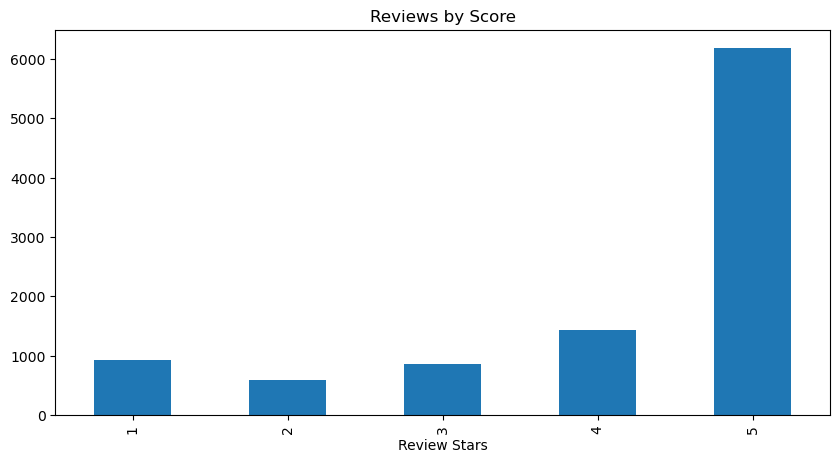

In [22]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Reviews by Score', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [23]:
df['Score'].value_counts()

5    6183
4    1433
1     932
3     862
2     590
Name: Score, dtype: int64

In [24]:
duplicates = df[df.duplicated(subset=['ProductId', 'UserId', 'ProfileName', 'Time', 'Text'], keep=False)]
duplicates

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
466,467,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
2334,2335,B0001FQVCK,A5D06XJHDXK75,C. Po,3,3,5,1190592000,Chocolate Italian kisses - need I say more?,My family has been in love with Baci's ever si...
2336,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,5,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
2613,2614,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,4,4,4,1300579200,lots of uses for this green tea...,lots of uses for this green tea...<br /><br />...
2636,2637,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,3,4,2,1313107200,Way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2647,2648,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2653,2654,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...
2941,2942,B0002TJAZK,A3TVZM3ZIXG8YW,christopher hayes,7,11,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ..."
2943,2944,B0002TJAZK,A2ISKAWUPGGOLZ,M. S. Handley,2,4,1,1310774400,Kitty Junk Food,We have five cats - one an elderly cat of 15 y...


In [25]:
duplicates[duplicates['ProductId']=='B006N3IG4K']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
9231,9232,B006N3IG4K,A10H24TDLK2VDP,William Jens Jensen,0,0,3,1309824000,Unremarkable,"First, let me say that I prefer extra-bold K-C..."
9232,9233,B006N3IG4K,A10H24TDLK2VDP,William Jens Jensen,0,0,3,1309824000,Unremarkable,"First, let me say that I prefer extra-bold K-C..."
9411,9412,B006N3IG4K,A10H24TDLK2VDP,William Jens Jensen,2,2,3,1309824000,Unremarkable,"First, let me say that I prefer extra-bold K-C..."


# Data Cleaning

In [27]:
# Drop the duplicates
df.drop_duplicates(subset=['ProductId', 'UserId', 'ProfileName', 'Time', 'Text'], keep='first', inplace=True)
df.shape

(9988, 10)

# Feature Engineering 1

In [28]:
print("Positive reviews:", df[df['Score']>3].shape[0])
print("Negative reviews:", df[df['Score']<=3].shape[0])

Positive reviews: 7612
Negative reviews: 2376


In [29]:
df['Review'] = [1 if x>3 else 0 for x in df['Score']] # set 1 for positive reviews, 0 for negative reviews
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


### Add Word Count and Character Count feature

In [31]:
df['WordCount'] = df['Text'].apply(lambda x: len(x.split()))
df['CharacterCount'] = df['Text'].apply(lambda x: len(x))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140


### Add Helpfulness percentage feature

In [33]:
df["HelpfulnessPercentage"] = df[["HelpfulnessNumerator","HelpfulnessDenominator"]].apply(lambda x: ((x[0]/x[1])*100.0) if x[1] else 0.0, axis=1)
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.0


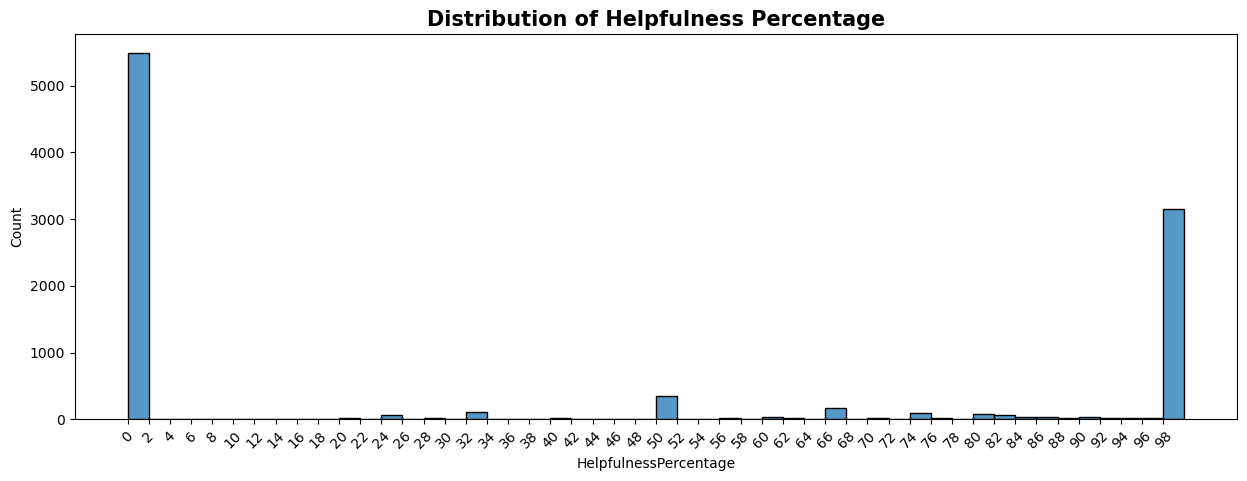

In [34]:
# Check the distribution of helpfulness percentage
plt.figure(figsize=(15,5))
sns.histplot(data=df["HelpfulnessPercentage"], bins=50)
plt.title("Distribution of Helpfulness Percentage",fontweight='bold', fontsize=15)
plt.xticks(range(0,100,2), rotation=45)
plt.show()

### Adding *Helpfulness Indicator* Feature

In [35]:
df.loc[df["HelpfulnessPercentage"] >= 75, 'HelpfulnessIndicator'] = 'Useful'
df.loc[(df["HelpfulnessPercentage"] > 40) & (df["HelpfulnessPercentage"] < 75), 'HelpfulnessIndicator'] = 'Intermediate'
df.loc[(df["HelpfulnessPercentage"] > 0) & (df["HelpfulnessPercentage"] <= 40), 'HelpfulnessIndicator'] = 'Not Useful'
df.loc[df["HelpfulnessPercentage"] == 0, 'HelpfulnessIndicator'] = 'Not Available'
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.0,Useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.0,Not Available
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.0,Useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.0,Useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.0,Not Available


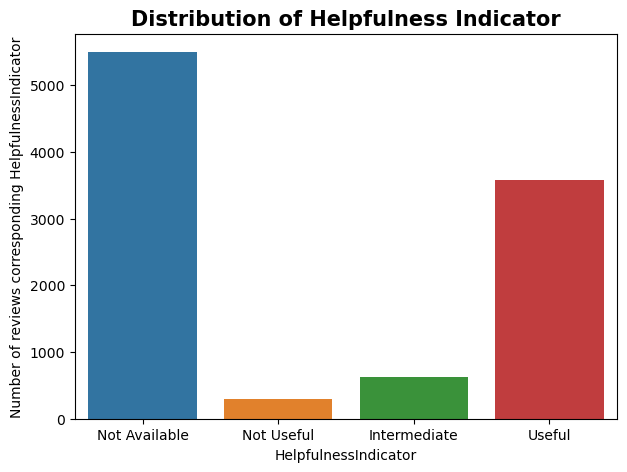


Not Available    5494
Not Useful        290
Intermediate      629
Useful           3575
Name: HelpfulnessIndicator, dtype: int64


In [36]:
plt.figure(figsize=(7,5))
sns.countplot(df, x='HelpfulnessIndicator', order=["Not Available","Not Useful","Intermediate","Useful"])
plt.title("Distribution of Helpfulness Indicator",fontweight='bold', fontsize=15)
plt.xlabel("HelpfulnessIndicator")
plt.ylabel("Number of reviews corresponding HelpfulnessIndicator")
plt.show()

print()

print(df['HelpfulnessIndicator'].value_counts()[[0,3,2,1]])

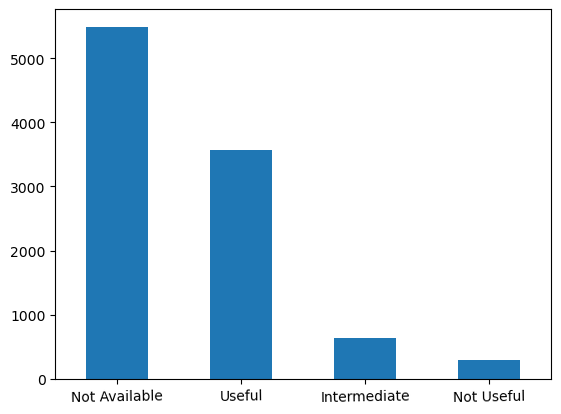


Count of Usefulness of Reviews:
Not Available    5494
Useful           3575
Intermediate      629
Not Useful        290
Name: HelpfulnessIndicator, dtype: int64


In [37]:
df.HelpfulnessIndicator.value_counts().plot(kind='bar', rot=1.0)
plt.show()
print("\nCount of Usefulness of Reviews:")
print(df.HelpfulnessIndicator.value_counts())

## Distribution of useful and non-useful reviews in each of the set of Positive and Negative Reviews

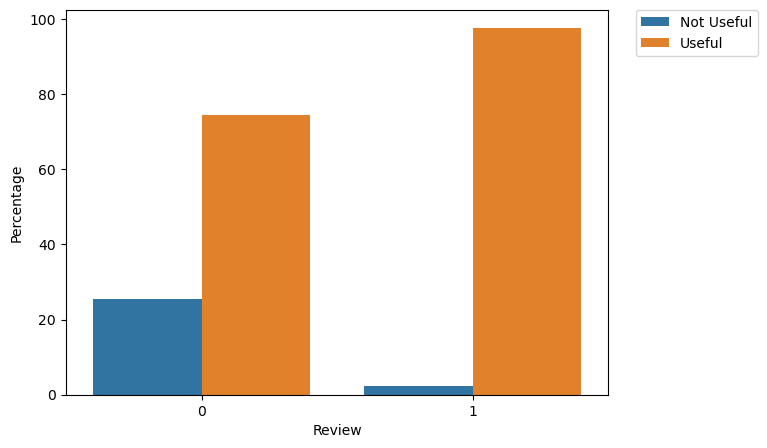

In [38]:
df_temp = df[(df["HelpfulnessIndicator"]!= "Not Available") & (df["HelpfulnessIndicator"]!= "Intermediate")]
df_temp_1 = df_temp["HelpfulnessIndicator"].groupby(df_temp["Review"]).value_counts(normalize=True)
df_temp_1 = df_temp_1*100
df_temp_1 = df_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=df_temp_1, x="Review", y="Percentage", hue="HelpfulnessIndicator", hue_order=["Not Useful", "Useful"]);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
print()

In [39]:
df_temp_1


,Review,HelpfulnessIndicator,Percentage
0,0,Useful,74.440518
1,0,Not Useful,25.559482
2,1,Useful,97.579576
3,1,Not Useful,2.420424


# Data Processing 1

In [40]:
import re
def clean_text(reviews_df):
  cleaned_reviews_df = []
  cleaned_reviews = ""
  for text in reviews_df:
    text = text.lower() # Converting to lowercase
    pattern = re.compile('<.*?>')
    text = re.sub(pattern, ' ', text) # Removing HTML tags
    text = re.sub(r'[?|!|\'|"|#]', r'', text)
    text = re.sub(r'[.|,|)|(|\|/]', r' ', text) # Removing Punctuations
    words = [word for word in text.split() if word not in stopwords.words('english')] # Removing stopwords
    cleaned_reviews_df.append(words)
    cleaned_reviews = list(map(' '.join, cleaned_reviews_df))
  return cleaned_reviews

In [41]:
df['CleanedText'] = clean_text(df['Text'])
df['CleanedText'][56:90]

56    deal awesome arrived halloween indicated enoug...
57    chocolate say great variety everything family ...
58    great product nice combination chocolates perf...
59    halloween sent bag daughters class share choco...
60    watch prices assortment good get gold box purc...
61    bag candy online pretty expensive cheaper orde...
62                arrived 6 days stale could eat 6 bags
63    used endurolyte product several years pill pow...
64    product serves well source electrolytes long r...
65    stuff really works preventing cramping middle ...
66    us low carb diet little tablets thing two year...
67    purchased mango flavor doesnt take like mango ...
68    youre impulsive like $6 ok dont get wrong qual...
69    sooooo deliscious bad ate em fast gained 2 pds...
70    albanese gummi bears rings good tasty high qua...
71    grape gummy bears hard find area fact pretty m...
72    ordered two two raspberry latice tarts directl...
73    buyer beware please sweetener everybody ma

## Word cloud for all reviews

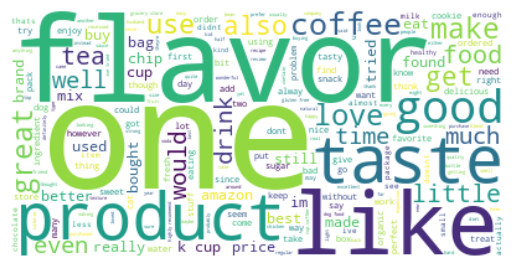

In [42]:
all_text = " ".join(review for review in df['CleanedText'])

wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word cloud for positive review

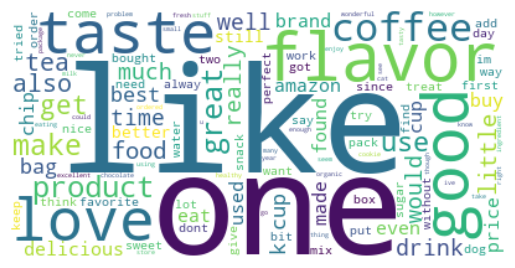

In [43]:
positive_text = " ".join(review for review in df['CleanedText'][df['Review']==1])

wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word cloud for negative reviews

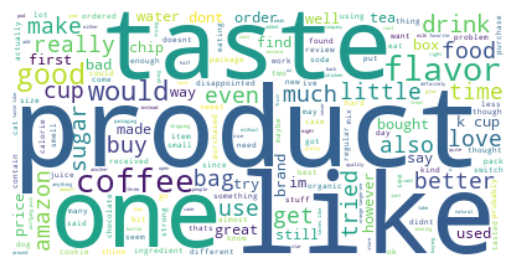

In [44]:
negative_text = " ".join(review for review in df['CleanedText'][df['Review']==0])

wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white").generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##Finding most common words in NEGATIVE REVIEWS and then plotting the word cloud:

In [45]:
# Tokenize the sentences in the corpus and create a dictionary with sentences and their frequencies
wordfreq = {}
tokens = nltk.word_tokenize(negative_text)
for t in tokens:
    if t not in wordfreq.keys():
        wordfreq[t] = 1
    else:
        wordfreq[t] += 1
print(wordfreq)

{'product': 817, 'arrived': 77, 'labeled': 14, 'jumbo': 8, 'salted': 3, 'peanuts': 14, 'actually': 123, 'small': 132, 'sized': 12, 'unsalted': 3, 'sure': 164, 'error': 6, 'vendor': 14, 'intended': 8, 'represent': 2, 'looking': 147, 'secret': 4, 'ingredient': 82, 'robitussin': 1, 'believe': 83, 'found': 208, 'got': 206, 'addition': 21, 'root': 10, 'beer': 18, 'extract': 38, 'ordered': 180, 'good': 713, 'made': 257, 'cherry': 19, 'soda': 195, 'flavor': 689, 'medicinal': 7, 'cats': 84, 'happily': 5, 'eating': 111, 'felidae': 17, 'platinum': 3, 'two': 203, 'years': 82, 'new': 117, 'bag': 210, 'shape': 17, 'food': 402, 'different': 185, 'tried': 365, 'first': 322, 'put': 129, 'bowls': 8, 'sit': 12, 'full': 90, 'kitties': 2, 'touch': 15, 'ive': 245, 'noticed': 56, 'similar': 50, 'reviews': 149, 'related': 8, 'formula': 49, 'changes': 5, 'past': 48, 'unfortunately': 85, 'need': 106, 'find': 223, 'eat': 239, 'love': 288, 'watching': 5, 'tv': 2, 'movies': 2, 'sweet': 217, 'like': 1289, 'transfe

In [46]:
# Filter down to 200 most frequently ocurring words:
import heapq
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)
print(most_freq)

['like', 'coffee', 'taste', 'product', 'one', 'would', 'good', 'flavor', 'dont', 'really', 'much', 'even', 'get', 'buy', 'food', 'better', 'im', 'drink', 'sugar', 'tried', 'water', ':', '-', 'also', 'amazon', 'juice', 'little', 'time', 'tea', 'cup', 'first', 'try', 'use', '$', 'love', 'price', 'bad', 'box', 'great', 'make', '3', 'bought', 'orange', 'chips', 'well', 'made', 'didnt', 'know', 'still', 'think', 'ive', '2', 'thought', 'way', 'eat', 'something', '%', 'mix', 'chocolate', 'could', 'order', 'find', 'ingredients', 'tastes', 'want', 'however', 'sweet', 'used', 'say', 'bag', 'found', 'got', 'two', 'hot', 'soda', 'doesnt', 'brand', 'bit', 'flavors', 'different', 'since', 'disappointed', 'ordered', 'products', 'tasted', 'less', 'never', 'best', 'go', 'though', '1', '4', 'give', 'money', 'sure', 'many', 'cant', 'organic', 'going', ';', 'milk', '--', 'away', 'pack', 'may', 'back', 'store', 'size', 'green', 'switch', 'reviews', '5', 'said', 'looking', 'see', 'stuff', 'people', 'free', 

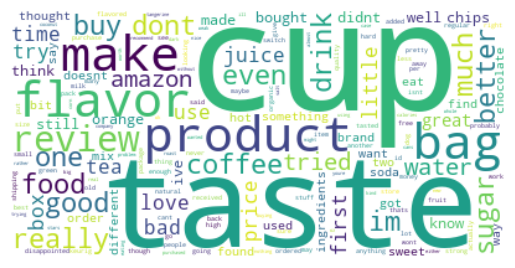

In [47]:
top_200_words = " ".join(word for word in most_freq)
wordcloud_top_200 = WordCloud(background_color="white").generate(top_200_words)
plt.imshow(wordcloud_top_200, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Processing 2

### Stemming

In [48]:
snow = nltk.stem.SnowballStemmer('english')
final_X = []
for text in df['CleanedText']:
  words = [snow.stem(word) for word in text.split()]
  final_X.append(words)
final_X[:10]

[['bought',
  'sever',
  'vital',
  'can',
  'dog',
  'food',
  'product',
  'found',
  'good',
  'qualiti',
  'product',
  'look',
  'like',
  'stew',
  'process',
  'meat',
  'smell',
  'better',
  'labrador',
  'finicki',
  'appreci',
  'product',
  'better'],
 ['product',
  'arriv',
  'label',
  'jumbo',
  'salt',
  'peanut',
  'peanut',
  'actual',
  'small',
  'size',
  'unsalt',
  'sure',
  'error',
  'vendor',
  'intend',
  'repres',
  'product',
  'jumbo'],
 ['confect',
  'around',
  'centuri',
  'light',
  'pillowi',
  'citrus',
  'gelatin',
  'nut',
  '-',
  'case',
  'filbert',
  'cut',
  'tini',
  'squar',
  'liber',
  'coat',
  'powder',
  'sugar',
  'tini',
  'mouth',
  'heaven',
  'chewi',
  'flavor',
  'high',
  'recommend',
  'yummi',
  'treat',
  'familiar',
  'stori',
  'c',
  'lewi',
  'lion',
  'witch',
  'wardrob',
  '-',
  'treat',
  'seduc',
  'edmund',
  'sell',
  'brother',
  'sister',
  'witch'],
 ['look',
  'secret',
  'ingredi',
  'robitussin',
  'believ',

# Convert to bag of words

In [49]:
stemmed_X = []
for row in final_X:
    sentence = ''
    for word in row:
        sentence = sentence + ' ' + word
    stemmed_X.append(sentence.strip())

In [50]:
stemmed_X[:5]

['bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better',
 'product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo',
 'confect around centuri light pillowi citrus gelatin nut - case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori c lewi lion witch wardrob - treat seduc edmund sell brother sister witch',
 'look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin',
 'great taffi great price wide assort yummi taffi deliveri quick taffi lover deal']

In [51]:
count_vect = CountVectorizer(max_features=100)
bow_X = count_vect.fit_transform(stemmed_X)
final_X = bow_X
print(final_X[:5])

  (0, 7)	1
  (0, 22)	1
  (0, 32)	1
  (0, 68)	3
  (0, 33)	1
  (0, 38)	1
  (0, 50)	1
  (0, 48)	1
  (0, 5)	2
  (1, 68)	2
  (2, 81)	1
  (2, 31)	1
  (2, 41)	1
  (2, 71)	1
  (2, 88)	2
  (3, 33)	1
  (3, 38)	1
  (3, 50)	1
  (3, 31)	1
  (3, 44)	1
  (3, 39)	1
  (3, 62)	1
  (3, 53)	1
  (4, 40)	2
  (4, 67)	1


In [53]:
final_y = df['Review']
print("Count of final_X:")
print(final_X.shape[0])
print()
print("Count of final_y:")
print(final_y.value_counts())

Count of final_X:
9988

Count of final_y:
1    7612
0    2376
Name: Review, dtype: int64


In [54]:
pca = PCA(n_components = 2)

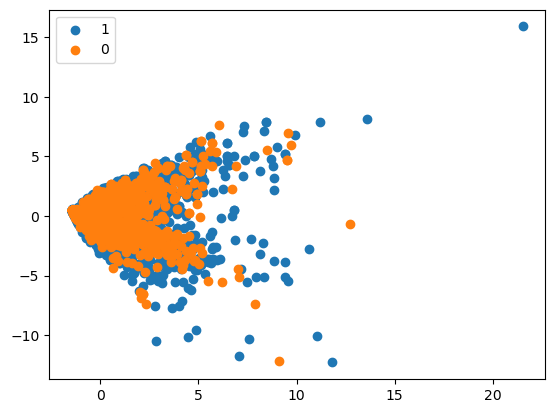

In [55]:
PCA_X = pca.fit_transform(final_X.toarray()) # Apply PCA to plot 2 dimensions

counter = Counter(final_y)
for label, _ in counter.items():
 row_ix = where(final_y == label)[0]
 plt.scatter(PCA_X[row_ix, 0], PCA_X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

# Applying SMOTE on dataset to balance it

In [56]:
oversample = SMOTE()

X_resampled, y_resampled = oversample.fit_resample(final_X, final_y)
X_resampled.shape

(15224, 100)

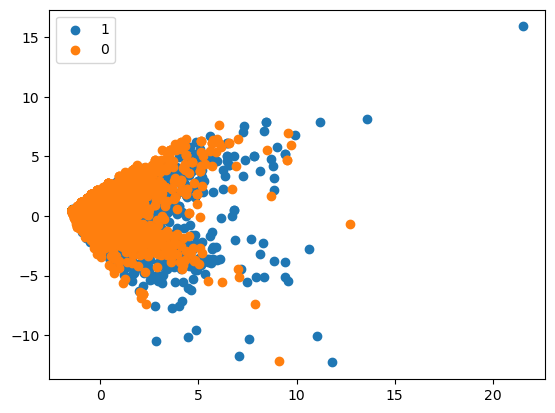

In [57]:
PCA_SMOTE_X = pca.transform(X_resampled.toarray())

for label, _ in counter.items():
 row_ix = where(y_resampled == label)[0]
 plt.scatter(PCA_SMOTE_X[row_ix, 0], PCA_SMOTE_X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [58]:
print("Shape of oversampled X:")
print(X_resampled.shape)
print()
print("Shape of oversampled y:")
print(y_resampled.shape)


Shape of oversampled X:
(15224, 100)

Shape of oversampled y:
(15224,)


In [59]:
df['StemmedText'] = stemmed_X
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review,WordCount,CharacterCount,HelpfulnessPercentage,HelpfulnessIndicator,CleanedText,StemmedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,48,263,100.0,Useful,bought several vitality canned dog food produc...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,31,190,0.0,Not Available,product arrived labeled jumbo salted peanuts p...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,94,509,100.0,Useful,confection around centuries light pillowy citr...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,41,219,100.0,Useful,looking secret ingredient robitussin believe f...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,27,140,0.0,Not Available,great taffy great price wide assortment yummy ...,great taffi great price wide assort yummi taff...


# (1) KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [61]:
y_pred = knn_classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [62]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6702791461412151

# (2) Naive Bayes classifier

In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
G_classifier = GaussianNB()
X_train = X_train.toarray()
G_classifier.fit(X_train, y_train)

GaussianNB()

In [64]:
X_test = X_test.toarray()

predictions_G = G_classifier.predict(X_test)
predictions_G

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [65]:
accuracy = metrics.accuracy_score(y_test, predictions_G)
accuracy

0.7057471264367816

In [ ]:
# BernoulliNB

In [66]:
B_classifier = BernoulliNB()
B_classifier.fit(X_train, y_train)

BernoulliNB()

In [67]:
predictions_B = B_classifier.predict(X_test)
predictions_B

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [68]:
accuracy_B = metrics.accuracy_score(y_test, predictions_B)
accuracy_B

0.7464696223316913

In [69]:
# MultinomialNB

In [70]:
M_classifier = MultinomialNB()
M_classifier.fit(X_train, y_train)

MultinomialNB()

In [71]:
predictions_M = M_classifier.predict(X_test)
predictions_M

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [72]:
accuracy_M = metrics.accuracy_score(y_test, predictions_M)
accuracy_M

0.7444991789819376

# (3) Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [74]:
y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.7839080459770115

# (4) Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
y_pred = rf_classifier.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.8371100164203612

# (5) Boosting Algorithm

In [77]:
from sklearn.ensemble import AdaBoostClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)
adaboost_classifier.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [78]:
y_pred = adaboost_classifier.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.7852216748768472

# Being the best of them | Random Forest Algorithm | accuracy 83.7%